# **Mô hình với Keras và TensorFlow**
> Chúng ta sẽ cùng đi qua về framework của Keras và Tensorflow để hiểu thêm được cách thức thực hiện xây dựng một mô hình phân loại hình ảnh với framework khác với fastai và pytorch.

In [ ]:
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing as PreprocessingLayers
from tensorflow.keras import backend as bk
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

**Kiểm tra version của tensorflow và số lượng GPU**

In [ ]:
print(tf.__version__, keras.__version__)

2.4.1 2.4.0


In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# Tạo path dữ liệu:
path = '../data'
!ls {path}

test  train


# Giới hạn GPU
> Một trong những điểm ưu việt của fastai vs tensorflow/keras là việc quản lý bộ nhớ của GPU. Với fastai, dữ liệu chỉ được load lên GPU để tính toán theo từng batch và được config mặc định như vậy, đảm bảo trong quá trình chạy model, nếu dữ liệu, model quá lớn thì ít xảy ra việc tràn bộ nhớ GPU. Với tensorflow, nếu chúng ta ko giới hạn bộ nhớ của GPU ngay từ đầu, trong quá trình tạo dữ liệu, toàn bộ dữ liệu sẽ mặc định được load lên GPU! Nếu dữ liệu của chúng ta quá lớn, có thể sẽ không thể load được, hoặc khi đào tạo model sẽ bị tràn bộ nhớ! Rất may mắm là tensorflow có cho người dùng tự config bộ nhớ sử dụng của GPU. Chúng ta sẽ phải config phần này mỗi lần chạy.

In [ ]:
# Giới hạn GPU:
gpu_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**Lưu ý:**
Bạn luôn phải chạy giới hạn GPU trước khi load dữ liệu, nếu không, bạn sẽ thấy lỗi sau:

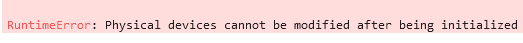

Nếu bạn bị lỗi này thì bắt buộc phải restart lại notebook và chạy lại từ đầu.

In [ ]:
# Kiểm tra lại GPU:
!nvidia-smi

Thu Sep  2 18:04:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.01    Driver Version: 471.41       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 38%   42C    P8    15W / 180W |   1080MiB /  8192MiB |    ERR!      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Tạo dữ liệu
> Trong tensorflow có 2 phương pháp tạo dữ liệu ảnh chính là:
> 1) `image_dateset_from_directory`
> 2) `ImageDataGenerator`
>
> Chúng ta có thể đi qua cả 2 phương pháp này, về cơ bản, phương pháp 1 là phương pháp mới được phát triển từ tf v2.3, trong khi phương pháp cũ là từ tf v1. Sự khác biệt cơ bản của 2 phương pháp này ở chỗ, vs `image_dataset_from_directory`, chúng ta sẽ chỉ khai báo các thuộc tính cơ bản của dữ liệu, trong khi `ImageDataGenerator` lại tập trung vào các phương pháp biến đổi dữ liệu (augmentation). Phương pháp 1 giúp chúng ta linh động hơn với các phương pháp biến đổi dữ liệu và có thể thử nhiều phương pháp vs nhau. Đi kèm vs phương pháp load dữ liệu này sẽ là 1 phần layer chuyên để biến đổi dữ liệu `preprocessing` trong `keras.layers.experimental`. Chúng ta sẽ đi tiếp ở dưới.


## image_dataset_from_directory

Với tensorflow verion 2.3, chúng ta có thể sử dụng `keras.preprocessing` để load dữ liệu từ folder thông qua phương thức `image_dataset_from_directory`. Các version thấp hơn, chúng ta phải khá vất vả để xử lý dữ liệu từ folder giống như cách fastai đang làm.

### Tạo dataset

**Chúng ta sẽ tạo dữ liệu tương đồng với cách tạo dữ liệu của fastai:**

In [ ]:
# Tạo dữ liệu
bs = 32
seed = 42
train_ds = image_dataset_from_directory(
    f'{path}/train/'
    , labels='inferred'
    , label_mode='binary'
    , batch_size=bs
    , image_size=(460, 460)
    , seed=seed
    , validation_split=.2
    , subset='training'
)

valid_ds = image_dataset_from_directory(
    f'{path}/train/'
    , labels='inferred'
    , label_mode='binary'
    , batch_size=bs
    , image_size=(460, 460)
    , seed=seed
    , validation_split=.2
    , subset='validation'
)

Found 713 files belonging to 2 classes.
Using 571 files for training.
Found 713 files belonging to 2 classes.
Using 142 files for validation.


**Lưu ý:** 

Ở đây chúng ta chỉ thuần túy tạo dữ liệu bằng cách load các hình ảnh từ folder đã được cấu trúc sẵn mà không có bất kỳ bước biến đổi dữ liệu nào cả (data augmentation).

In [ ]:
# Kiểm tra lại bộ nhớ GPU:
!nvidia-smi

Thu Sep  2 18:04:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.01    Driver Version: 471.41       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 38%   43C    P2    43W / 180W |   1302MiB /  8192MiB |    ERR!      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Kiểm tra dữ liệu:**

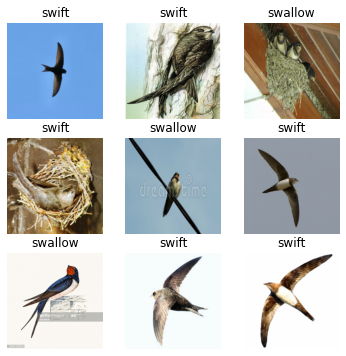

In [ ]:
class_names = train_ds.class_names
plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):
    # Lấy 9 ảnh:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.uint8(images[i]))
        plt.title(class_names[np.int(labels[i])]) # Đây là cách lấy dữ liệu dạng binary
        plt.axis("off")

### Augmentation
> Với biến đổi dữ liệu cho hình ảnh, chúng ta có thể sử dụng preprocess layers để xử lý các bài toán biến đổi dữ liệu (augmentation).
> Ở đây chúng ta sẽ chỉ làm 3 phương pháp cơ bản nhất:
> 1. Crop ảnh về size 224: khác vs resize, có thể làm co, méo, mờ ảnh ảnh khi đẩy về size nhỏ hơn hoặc lớn hơn, crop ảnh sẽ giữ nguyên ảnh ban đầu, nếu nhỏ hơn sẽ chỉ lấy phần đủ 224, hoặc bổ sung thêm ảnh (đen - 0, gần nhất, tương phản..)
> 2. Rescale: đẩy pixcel từ 0-255 về 0-1
> 3. Normalization: normalize dữ liệu về khoảng mean và std phù hợp (ví dụ mean 0, std 1)
>
>Với phương pháp 2, 3, chúng ta sẽ sử dụng luôn proprocess_input của ResNet do chúng ta đang muốn sử dụng pretrained của ResNet.

In [ ]:
# Tạo preprocess layer:
preprocesing_layer = keras.Sequential([
    PreprocessingLayers.RandomCrop(224, 224),
    keras.layers.Lambda(lambda x: keras.applications.resnet.preprocess_input(x))
])

Với tensorflow dataset, khi muốn thực hiện các biến đổi dữ liệu, chúng ta phải sử dụng phương pháp `map` để làm việc này:

In [ ]:
# Tạo maping function:
def preprocessing_image(image, label):
    image = preprocesing_layer(image)
    return image, label

In [ ]:
# Áp dụng biến đổi dữ liệu vào dataset:
train_ds = train_ds.map(preprocessing_image)
valid_ds = valid_ds.map(preprocessing_image)

# Tune dữ liệu để tốc độ chạy được nhanh hơn:
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(tf.data.AUTOTUNE)

## ImageDataGenerator
> `ImageDataGenerator` là phương pháp tạo dataset cũ, cho phép khai báo luôn các phương pháp biến đổi dữ liệu luôn trong khi tạo dataset. Các phương pháp biến đổi cơ bản bao gồm:
> 1. Normalization
> 2. zca
> 3. rotation
> 4. shift
> 5. brightness
> 6. shear
> 7. zoom
> 8. flip

Chúng ta sẽ đi qua các phương pháp từ 2 đến 8 ở đây.

In [ ]:
# Tạo dữ liệu:
def create_dataset(aug_tfms: dict):
    return ImageDataGenerator(**aug_tfms, validation_split=.1)\
    .flow_from_directory(
        f'{path}/train', 
        target_size=(224, 224),
        batch_size=9,
        shuffle=True,
        seed=42, 
        subset='validation', 
        class_mode='binary'
    )

# Vẽ dữ liệu:
def plot_images(aug_tfms, repeat: bool=True):
    dataset = create_dataset(aug_tfms)
    class_names = list(dataset.class_indices.keys())
    np.random.seed()
    idx = np.random.randint(9)
    if repeat: 
        images = [dataset[0][0][idx] for i in range(9)]
        labels = [dataset[0][1][idx] for i in range(9)]
    else: 
        images = dataset[0][0]
        labels = dataset[0][1]
    plt.figure(figsize=(6, 6))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i]/255.)
        plt.title(class_names[np.int8(labels[i])])
        plt.axis('off')
        plt.tight_layout()

### zca

Found 70 images belonging to 2 classes.


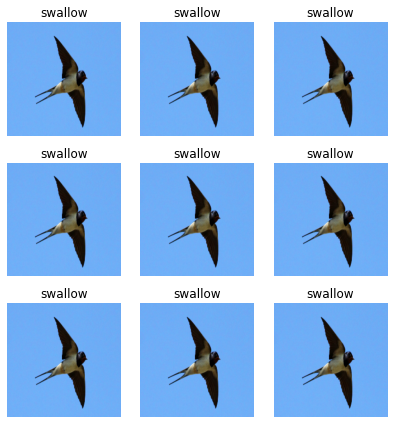

In [ ]:
aug_tfms = dict(zca_whitening=True) 
# sample = create_dataset(aug_tfms)
plot_images(aug_tfms)

### Rotation

Found 70 images belonging to 2 classes.


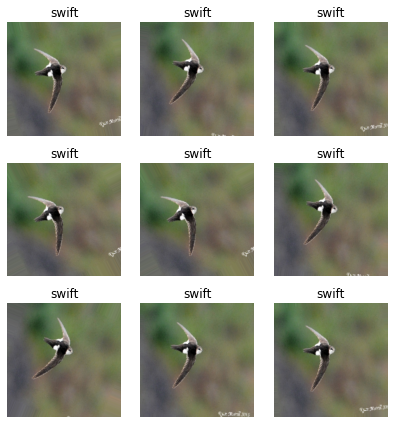

In [ ]:
aug_tfms = dict(rotation_range=30)
plot_images(aug_tfms, True)

### Shift

Found 70 images belonging to 2 classes.


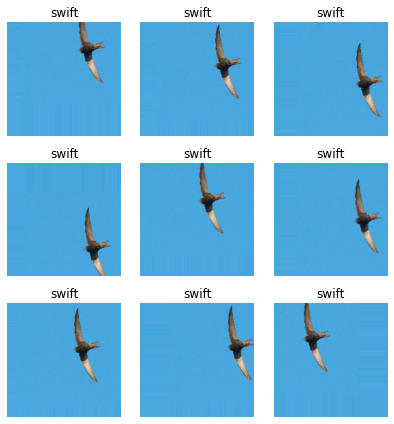

In [ ]:
aug_tfms = dict(width_shift_range=.3, height_shift_range=-.3)
plot_images(aug_tfms, True)

### Brightness

Found 70 images belonging to 2 classes.


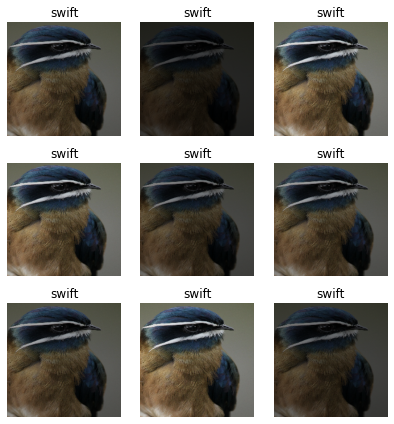

In [ ]:
aug_tfms = dict(brightness_range=(.2, .95))
plot_images(aug_tfms, True)

### Shear

Found 70 images belonging to 2 classes.


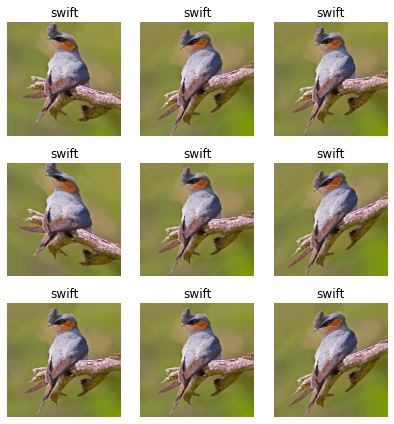

In [ ]:
aug_tfms = dict(shear_range=30)
plot_images(aug_tfms, True)

### Zoom

Found 70 images belonging to 2 classes.


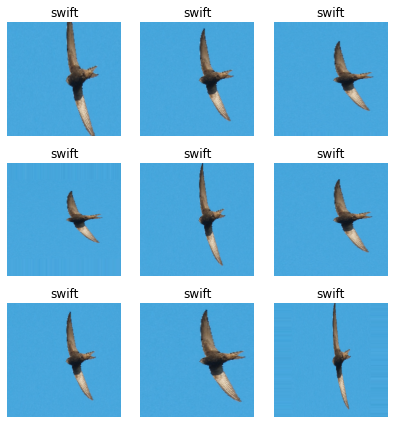

In [ ]:
aug_tfms = dict(zoom_range=[1-.5, 1+.5])
plot_images(aug_tfms, True)

### Flip

Found 70 images belonging to 2 classes.


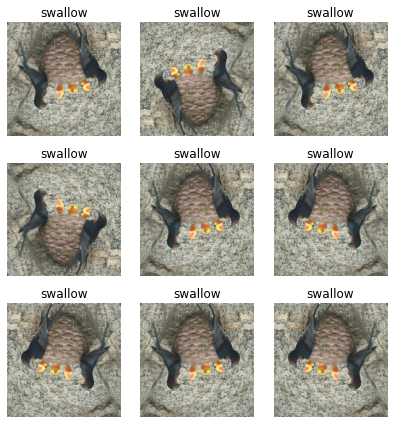

In [ ]:
aug_tfms = dict(horizontal_flip=True, vertical_flip=True)
plot_images(aug_tfms, True)

# Xây dựng mô hình
> Tương tự như fastai, chúng ta sẽ sử dụng lại model đã được học rồi (pretrained) cho bài toán của chúng ta. Chúng ta sẽ tập trung với ResNet model.

**Lưu ý:**

Khác với fastai, với Keras/Tensorflow, để sử dụng mô hình đã học rồi, chúng ta hoặc sẽ sử dụng toàn bộ kiến trúc cũ, hoặc sẽ phải cắt bỏ lớp (layers) cuối cùng của kiến trúc cũ để tinh chỉnh theo bài toán mà chúng ta cần. Keras có cho lựa chọn `include_top` để chúng ta có thể thực hiện được việc này.

In [ ]:
resnet_model = keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=[224, 224, 3])

Xem kiến trúc của mô hình:

In [ ]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

**Bổ sung lớp cần thiết cho bài toán của chúng ta:**

Chúng ta sẽ cần bổ sung thêm 2 lớp nữa cho mô hình đã học rồi:

1. Flatten: Kéo dãn dữ liệu đầu vào (3 chiều) của lớp trước thành array 1 chiều.
2. Dense: tạo lớp cơ bản và trả về kết quả dự đoán 2 giá trị.

In [ ]:
flatten = keras.layers.Flatten()(resnet_model.output)
predictions = keras.layers.Dense(1, activation='sigmoid', name="predictions")(flatten)
model = keras.models.Model(inputs=resnet_model.input, outputs=predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

**Tổng hợp mô hình:**

Với Keras, sau khi đã xây dựng xong kiến trúc, chúng ta cần tổng hợp lại mô hình và bổ sung phần còn lại của mô hình bao gồm:

- optimizer: thuật toán tối ưu sử dụng 
- loss: hàm mất mát
- metrics: các chỉ số được sử dụng

Với `leaner` và `cnn_learner` của fastai, chúng ta cũng có bước tương tự như vậy, tuy nhiên một vài thông số chúng ta có thể để mặc định được do các thông số này đã được tối ưu hóa. Ví dụ optimizer của fastai thực tế là `adam`, trong khi ở đây chúng ta đang sử dụng `rmsprop`.

Để nói thêm về thuật toán tối ưu sẽ mất khá nhiều thời gian, vì đây là phần cốt lõi (building bloc) của học sâu và mạng thần kinh (Neural Network), và luôn được gắn liền với tốc độ học (learning rate). Tương tự như vậy là `Initialization` và `Activation fuction`.

**Tạo metrics F1 cho mô hình:**

Do keras không có F1 nên chúng tao sẽ phải tạo hàm để tính chỉ số này cho mô hình của chúng ta. Để nắm thêm kiến thức về các chỉ số này, chúng ta có thể tham khảo định nghĩa về [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). Trong tình huống của chúng ta, confusion matrix sẽ được biểu diễn như sau:

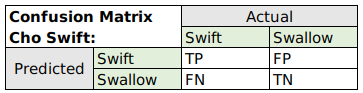

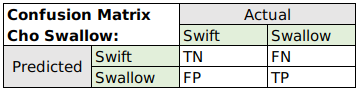

Như vậy, công thức tính các chỉ số sẽ như sau: 

- `Precision`:

$precision = \frac{TP}{TP + FP}$

- `Recall`:

$recall = \frac{TP}{TP+FN}$

- `Accuracy`:

$accuracy = \frac{TP + TN}{TP + FP + TN + FN}$

- `F1`:

$f1 = 2 \times \frac{precision \times recal}{precision + recall} = \frac{2TP}{2TP + FP + FN}$

Chúng ta sẽ sử dụng backend của keras để tính chỉ số f1 theo công thức trên. Mặc dù chúng ta đã có 

Lời giải này dựa theo lời giả trên lời giải trên [datascience.stackexchange.com](https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model)

In [ ]:
def f1(y_true, y_pred):
    # Tính True Positive:
    TP = bk.sum(bk.round(bk.clip(y_true * y_pred, 0, 1)))
    
    # Tính Actual Positve: TP + FN
    TP_FN = bk.sum(bk.round(bk.clip(y_true, 0, 1)))
    
    # Tính Predicted Positve: TP + FP
    TP_FP = bk.sum(bk.round(bk.clip(y_pred, 0, 1)))
    
    return  (2 * TP)/(TP_FN + TP_FP + bk.epsilon())

In [ ]:
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy', f1])

Chúng ta sẽ làm thêm một việc nữa là "đóng băng" các lớp trước của mô hình đã học. Sau khi chúng ta có kết quả tốt rồi, việc "giã đông" để học lại với các lớp trước sẽ là bước cuối cùng.

In [ ]:
for layer in model.layers[:-2]:
    layer.trainable = False

In [ ]:
model.fit(train_ds, epochs=20, validation_data=valid_ds)

Epoch 1/20
18/18 [==============================] - 59s 2s/step - loss: 4.3306 - accuracy: 0.6266 - f1: 0.6279 - val_loss: 4.8068 - val_accuracy: 0.6761 - val_f1: 0.6595
Epoch 2/20
18/18 [==============================] - 2s 121ms/step - loss: 1.9749 - accuracy: 0.8579 - f1: 0.8415 - val_loss: 2.2487 - val_accuracy: 0.8310 - val_f1: 0.8438
Epoch 3/20
18/18 [==============================] - 2s 127ms/step - loss: 0.4357 - accuracy: 0.9592 - f1: 0.9617 - val_loss: 5.2354 - val_accuracy: 0.7535 - val_f1: 0.8169
Epoch 4/20
18/18 [==============================] - 2s 122ms/step - loss: 0.5531 - accuracy: 0.9412 - f1: 0.9464 - val_loss: 5.5538 - val_accuracy: 0.7113 - val_f1: 0.7855
Epoch 5/20
18/18 [==============================] - 2s 126ms/step - loss: 1.2977 - accuracy: 0.8872 - f1: 0.9054 - val_loss: 3.5158 - val_accuracy: 0.8451 - val_f1: 0.8486
Epoch 6/20
18/18 [==============================] - 2s 118ms/step - loss: 0.2347 - accuracy: 0.9812 - f1: 0.9845 - val_loss: 3.9421 - val_accu

**Lưu ý:**
Quan sát ảnh dưới đây:



Bạn có thể nhận thấy, khi mô hình đang học, ngay dưới phần số lượng epoch trên tổng số epoch cần học sẽ là số lượng lần học trên tổng số lần học trong từng epoch đó. Ở đây, chúng ta có 23 lần học (interation) cho 1 epoch. Với tổng số 714 ảnh cho tập train (xem kết quả phần `Tạo dữ liệu`) và với bach_size là 32, thì chúng ta sẽ có 22 lần học đủ 32 ảnh và 1 lần học cuối cùng với chỉ 10 ảnh (714 = 22*32 + 10). 

**Kết quả học:**


Chúng ta có thể thấy được với 20 epochs, kết quả f1 và accuracy của cả train và valid là tương đối thấp, so sánh với kết quả khi sử dụng fastai. Sự khác biệt đến từ rất nhiều lý do khác nhau như: data augmentation (biến đổi dữ liệu); tốc độ học (learning rate) và phương pháp đặt lịch cho tốc độ học (learning rate schedule).

Chúng ta có thể cải thiện kết quả này hơn thông qua các bước sau:
1. Cải thiện dữ liệu đầu vào (thông qua việc biến đổi dữ liệu - data augmentation) - ở đây chúng ta chỉ thuần túy load dữ liệu vào mà thôi.
2. Cải thiện việc sử dụng tốc độ học (learning rate) và phương pháp đặt lịch cho tốc độ học (learning rate schedule). Hiện chúng ta đang để `lr` dưới dạng default.

Chúng ta sẽ thử cả 2 cách trên với Keras. Đây chính là điểm khác biệt giữa Keras/Tensorflow với fastai, với những người mới học hoặc kể cả những người đã có kinh nghiệm, việc tối ưu mô hình học sâu tốn kém thời gian cũng như công sức và tiền của. Có nên chăng hãy để cho các chuyên gia làm việc này và chúng ta chỉ cần thừa hưởng lại những kết quả mà thôi.

## Đánh giá kết quả

**Lưu ý:**

Chúng ta mong muốn có thể xem được các bức ảnh mà mô hình đã nhận diện sai để có thể đáng giá được các vấn đề chính mà mô hình đang mắc phải và có thể đưa ra một vài kết luận cho việc khắc phục mô hình.